In [1]:
# Warning: Notebook can take around 3 minutes to run

# Predicting Vaccinations Against Infectious Diseases
## Machine learning modeling project
Flatiron School Data Science: Project 3
- **Author**: Zaid Shoorbajee
- **Instructor**: Matthew Bombard
- **Pace**: Flex, 20 weeks

## Overview and Business Understanding

It's part of the role of public health authorities to oversee the production and distribution of vaccines to the public, as well as to inform the public about vaccines' use and effectiveness. Along with the tragedy and global upheaval of the COVID-19 pandemic came the problem of fighting vaccine hesitancy. Someone's decision get or to not get the shot could be influenced by their demographic background, opinions about vaccines, as well as healthcare circumstances.

In this scenario, a public health agency wants to use data and machine learning understand what factors affect someone's decision to get vaccinated. It also wants to be able to predict whether someone will get vaccinated based on those factors. This is an exercise that might aid in vaccination efforts for the current COVID-19 pandemic, but it also can inform efforts to get ahead of the crisis should another epidemic arise.

## Data Understanding

As COVID-19 has consumed the world's collective attention for more than two years, it's easy to forget that the world dealt with another pandemic not too long ago. Although it didn't disrupt world activities the same way COVID-19 has, the H1N1 virus (A.K.A swine flu) was a major cause for concern in 2009 and 2010.

At the time, public health authorities in the U.S. sought to understand more about people's immunization behaviors as a result of the H1N1 outbreak. The Centers for Disease Control and Prevention (CDC) conducted phone surveys, collecting information about whether individuals had gotten the H1N1 and seasonal flu vaccines during the 2009-2010 flu season. The survey also recorded their opinions on the vaccines, viruses, and demographic information.

Machine learning is a good approach to solve this problem because of the extensive amount of variables that can be used to predict the vaccination outcomes. ML algorithms are about to take in a multitude of predictors and learn which ones have the greatest effect on the outcome. The algorithm can use those findings to predict outcomes for data it hasn't seen. These are conclusions would be more limited in scope and time-consuming to reach if one were using a simpler form of statistical analysis.

### Dataset and features
Data from this survey has been made available through a competition hosted by <a href="https://www.drivendata.org/competitions/66/flu-shot-learning/page/210/">DrivenData</a>.

The dataset contains answers from 26,707 survey respondents with 35 features. The features include:
* Behavioral information (E.g. Did respondent bought a face mask? Do they wash their hands frequently?
* Health care information (E.g. Do they have health insurance? Did a doctor recommend they get the seasonal and/or H1N1 vaccine?)
* Demographic information (E.g. age group, education level, race)
* Socioeconomic information (E.g. income level, homeowner status, number of household adults and children)
* Geographic information (Region and whether they live in a metropolitan area)
* Employment information (industry and occupation)

The features are a combination of binary, ordinal, and categorical variables.

### Target variable
The target variables available are two binary variables representing whether the respondent received a seasonal flu vaccine and whether they received an H1N1 vaccine. **This project will focus on one target variable: receiving the H1N1 vaccine.**

### Scoring

The metric I will use to evaluate model performance is the area under the curve of the receiver operating characteristic (AUROC). This is a commonly reported metric that accounts for the true positive rate (TPR) and the false positive rate (FPR). It essentially tells the probability that the model is able to discriminate between positive cases and negative cases. This will probably be more informative than accuracy, since the target set is somewhat imbalanced; about 21% of respondents received the H1N1 vaccine. 

AUROC is also the metric being used to judge the DrivenData competition.

## Data preparation

In [2]:
# Imports

# This part is to record how long the notebook takes to run
import time
start_time = time.time()

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import confusion_matrix, get_scorer

pd.options.display.max_columns = None
seed = 50

**Reading in the dataset**. This is from an online competition on DrivenData, so the provided test set doesn't have labels. For this reason I'll treat the provided training set and labels as a the whole dataset, on which I will later peform a train-test split.

In [3]:
features = pd.read_csv('data/training_set_features.csv')
target = pd.read_csv('data/training_set_labels.csv')

In [4]:
data = pd.concat([features, target], axis=1)

In [5]:
data = data.drop(columns=['respondent_id', 'seasonal_vaccine'])

In [6]:
data.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,0
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,0.0,NaN,3.0,1.0,1.0,4.0,1.0,2.0,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,3.0,3.0,5.0,5.0,4.0,1.0,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,0
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,3.0,2.0,3.0,1.0,4.0,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,0


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 36 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_concern                 26615 non-null  float64
 1   h1n1_knowledge               26591 non-null  float64
 2   behavioral_antiviral_meds    26636 non-null  float64
 3   behavioral_avoidance         26499 non-null  float64
 4   behavioral_face_mask         26688 non-null  float64
 5   behavioral_wash_hands        26665 non-null  float64
 6   behavioral_large_gatherings  26620 non-null  float64
 7   behavioral_outside_home      26625 non-null  float64
 8   behavioral_touch_face        26579 non-null  float64
 9   doctor_recc_h1n1             24547 non-null  float64
 10  doctor_recc_seasonal         24547 non-null  float64
 11  chronic_med_condition        25736 non-null  float64
 12  child_under_6_months         25887 non-null  float64
 13  health_worker   

In [8]:
(data.isna().sum() / len(data)) * 100

h1n1_concern                    0.344479
h1n1_knowledge                  0.434343
behavioral_antiviral_meds       0.265848
behavioral_avoidance            0.778822
behavioral_face_mask            0.071142
behavioral_wash_hands           0.157262
behavioral_large_gatherings     0.325757
behavioral_outside_home         0.307036
behavioral_touch_face           0.479275
doctor_recc_h1n1                8.087767
doctor_recc_seasonal            8.087767
chronic_med_condition           3.635751
child_under_6_months            3.070356
health_worker                   3.010447
health_insurance               45.957989
opinion_h1n1_vacc_effective     1.464036
opinion_h1n1_risk               1.452803
opinion_h1n1_sick_from_vacc     1.479013
opinion_seas_vacc_effective     1.729884
opinion_seas_risk               1.924589
opinion_seas_sick_from_vacc     2.010709
age_group                       0.000000
education                       5.268282
race                            0.000000
sex             

#### Observations:
There are several features with a large amount of data missing. I'll have to either impute them with some value or drop them. 

In particular, `health_insurance` has 46% of its data missing, but I would rather not drop that whole feature because it seems pertinent to the matter of taking an H1N1 vaccine. 

`employment_industry` and `employment_occupation` have half their data missing. The values are encoded in an odd way and are not interpretable, so I'll drop these columns.

In [9]:
X = data.drop(columns=['h1n1_vaccine', 'employment_industry', 'employment_occupation'])
y = data['h1n1_vaccine']

#### Train-test split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed)

In [11]:
# Separate numerical and object columns in order to use different imputing strategies

X_train_num = X_train.select_dtypes('number')
X_train_obj = X_train.select_dtypes('object')

# Encoding object columns with numbers

ord_encoder = OrdinalEncoder()
X_train_obj = pd.DataFrame(ord_encoder.fit_transform(X_train_obj), columns=X_train_obj.columns, index=X_train_obj.index)

#### Imputing all missing values with the mean or nearest neighbor

In [12]:
num_imputer = SimpleImputer(strategy='mean')
obj_imputer = KNNImputer()

In [13]:
# Imputing missing numerical values with the mean from that column
imputed_x_train_num = pd.DataFrame(num_imputer.fit_transform(X_train_num), columns=X_train_num.columns, index=X_train_num.index)

# Imputing missing object values with the nearest neighbor
imputed_x_train_obj = obj_imputer.fit_transform(X_train_obj)

# Undoing the ordinal encoding, in order to one-hot encode
imputed_x_train_obj = pd.DataFrame(ord_encoder.inverse_transform(imputed_x_train_obj), columns=X_train_obj.columns, index=X_train_obj.index)

# Combining the numerical and object data
X_train_imp = pd.concat(
    [
       imputed_x_train_num,
       imputed_x_train_obj
    ],
    axis=1
)

In [14]:
X_train_imp.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,household_adults,household_children,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa
16087,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.000000,5.0,2.0,4.0,5.0,2.0,1.0,2.0,0.0,18 - 34 Years,Some College,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,oxchjgsf,"MSA, Principle City"
9261,2.0,2.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.880081,5.0,2.0,4.0,5.0,4.0,1.0,1.0,0.0,65+ Years,College Graduate,White,Male,"> $75,000",Married,Own,Employed,bhuqouqj,Non-MSA
16193,2.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.880081,5.0,2.0,2.0,5.0,4.0,2.0,0.0,2.0,45 - 54 Years,College Graduate,White,Female,"<= $75,000, Above Poverty",Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City"
18216,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.880081,4.0,4.0,4.0,5.0,2.0,1.0,0.0,0.0,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Not Married,Rent,Employed,dqpwygqj,"MSA, Principle City"
9161,2.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.000000,5.0,4.0,1.0,5.0,5.0,1.0,1.0,0.0,55 - 64 Years,12 Years,White,Male,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City"


No more missing values

In [15]:
X_train_imp.isna().sum()

h1n1_concern                   0
h1n1_knowledge                 0
behavioral_antiviral_meds      0
behavioral_avoidance           0
behavioral_face_mask           0
behavioral_wash_hands          0
behavioral_large_gatherings    0
behavioral_outside_home        0
behavioral_touch_face          0
doctor_recc_h1n1               0
doctor_recc_seasonal           0
chronic_med_condition          0
child_under_6_months           0
health_worker                  0
health_insurance               0
opinion_h1n1_vacc_effective    0
opinion_h1n1_risk              0
opinion_h1n1_sick_from_vacc    0
opinion_seas_vacc_effective    0
opinion_seas_risk              0
opinion_seas_sick_from_vacc    0
household_adults               0
household_children             0
age_group                      0
education                      0
race                           0
sex                            0
income_poverty                 0
marital_status                 0
rent_or_own                    0
employment

#### One-hot encoding and scaling

In [16]:
X_train_ohe = pd.get_dummies(X_train_imp)

In [17]:
scaler = StandardScaler()

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_ohe), columns=X_train_ohe.columns, index=X_train_ohe.index)

In [18]:
X_train_scaled.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,household_adults,household_children,age_group_18 - 34 Years,age_group_35 - 44 Years,age_group_45 - 54 Years,age_group_55 - 64 Years,age_group_65+ Years,education_12 Years,education_< 12 Years,education_College Graduate,education_Some College,race_Black,race_Hispanic,race_Other or Multiple,race_White,sex_Female,sex_Male,"income_poverty_<= $75,000, Above Poverty","income_poverty_> $75,000",income_poverty_Below Poverty,marital_status_Married,marital_status_Not Married,rent_or_own_Own,rent_or_own_Rent,employment_status_Employed,employment_status_Not in Labor Force,employment_status_Unemployed,hhs_geo_region_atmpeygn,hhs_geo_region_bhuqouqj,hhs_geo_region_dqpwygqj,hhs_geo_region_fpwskwrf,hhs_geo_region_kbazzjca,hhs_geo_region_lrircsnp,hhs_geo_region_lzgpxyit,hhs_geo_region_mlyzmhmf,hhs_geo_region_oxchjgsf,hhs_geo_region_qufhixun,"census_msa_MSA, Not Principle City","census_msa_MSA, Principle City",census_msa_Non-MSA
16087,-0.675263,-0.423433,-0.226876,0.613266,-0.271729,0.457501,-0.748773,-0.718063,0.687215,-0.550405,-0.726445,1.615694,-0.302783,-0.361247,5.027249e-01,1.144717,-0.268425,1.218449,0.901472,-0.525359,-0.846847,1.476925,-0.577187,2.011619,-0.409959,-0.491873,-0.513151,-0.584614,-0.530961,-0.361056,-0.819472,1.673978,-0.293341,-0.265721,-0.253896,0.508956,0.824503,-0.824503,-1.273740,-0.620491,2.945561,-1.114674,1.114674,-1.870318,1.870318,-1.109285,1.243024,-0.242215,-0.285234,-0.347578,-0.207916,-0.375221,-0.347036,-0.287784,-0.440498,-0.301889,2.911173,-0.363260,-0.883607,1.549040,-0.604152
9261,0.422204,1.197152,-0.226876,0.613266,-0.271729,0.457501,1.339799,1.397240,0.687215,-0.550405,1.494290,-0.642439,-0.302783,-0.361247,4.654300e-16,1.144717,-0.268425,1.218449,0.901472,0.935203,-0.846847,0.147572,-0.577187,-0.497112,-0.409959,-0.491873,-0.513151,1.710530,-0.530961,-0.361056,1.220298,-0.597379,-0.293341,-0.265721,-0.253896,0.508956,-1.212852,1.212852,-1.273740,1.611627,-0.339494,0.897123,-0.897123,0.534668,-0.534668,0.901482,-0.804490,-0.242215,-0.285234,2.877055,-0.207916,-0.375221,-0.347036,-0.287784,-0.440498,-0.301889,-0.343504,-0.363260,-0.883607,-0.645561,1.655213
16193,0.422204,1.197152,-0.226876,0.613266,-0.271729,0.457501,-0.748773,-0.718063,0.687215,1.972218,1.494290,1.615694,-0.302783,-0.361247,4.654300e-16,1.144717,-0.268425,-0.263629,0.901472,0.935203,-0.088790,-1.181781,1.596300,-0.497112,-0.409959,2.033043,-0.513151,-0.584614,-0.530961,-0.361056,1.220298,-0.597379,-0.293341,-0.265721,-0.253896,0.508956,0.824503,-0.824503,0.785089,-0.620491,-0.339494,-1.114674,1.114674,-1.870318,1.870318,0.901482,-0.804490,-0.242215,-0.285234,2.877055,-0.207916,-0.375221,-0.347036,-0.287784,-0.440498,-0.301889,-0.343504,-0.363260,1.131725,-0.645561,-0.604152
18216,-0.675263,-0.423433,-0.226876,-1.643744,-0.271729,0.457501,-0.748773,-0.718063,-1.462084,-0.550405,1.494290,-0.642439,-0.302783,2.854550,4.654300e-16,0.148336,1.299229,1.218449,0.901472,-0.525359,-0.846847,-1.181781,-0.577187,-0.497112,-0.409959,2.033043,-0.513151,-0.584614,-0.530961,-0.361056,-0.819472,1.673978,-0.293341,-0.265721,-0.253896,0.508956,0.824503,-0.824503,0.785089,-0.620491,-0.339494,-1.114674,1.114674,-1.870318,1.870318,0.901482,-0.804490,-0.242215,-0.285234,-0.347578,4.809629,-0.375221,-0.347036,-0.287784,-0.440498,-0.301889,-0.343504,-0.363260,-0.883607,1.549040,-0.604152
9161,0.422204,-0.423433,-0.226876,0.613266,-0.271729,0.457501,-0.748773,-0.718063,0.687215,-0.550405,-0.726445,-0.642439,-0.302783,-0.361247,5.027249e-01,1.144717,1.299229,-1.004668,0.901472,1.665484,-0.846847,0.147572,-0.57718

#### Applying preprocessing steps to test set

In [19]:
X_test_num = X_test.select_dtypes('number')
X_test_obj = X_test.select_dtypes('object')
X_test_obj = pd.DataFrame(ord_encoder.transform(X_test_obj), columns=X_test_obj.columns, index=X_test_obj.index)

# Imputing missing numerical values with the mean from that column
imputed_x_test_num = pd.DataFrame(num_imputer.transform(X_test_num), columns=X_test_num.columns, index=X_test_num.index)

# Imputing missing object values with the nearest neighbor
imputed_x_test_obj = obj_imputer.transform(X_test_obj)

# Undoing the ordinal encoding, in order to one-hot encode
imputed_x_test_obj = pd.DataFrame(ord_encoder.inverse_transform(imputed_x_test_obj), columns=X_test_obj.columns, index=X_test_obj.index)

# Combining the numerical and object data
X_test_imp = pd.concat(
    [
       imputed_x_test_num,
       imputed_x_test_obj
    ],
    axis=1
)

X_test_ohe = pd.get_dummies(X_test_imp)

X_test_scaled = pd.DataFrame(scaler.transform(X_test_ohe), columns=X_test_ohe.columns, index=X_test_ohe.index)

In [20]:
X_test_scaled.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,household_adults,household_children,age_group_18 - 34 Years,age_group_35 - 44 Years,age_group_45 - 54 Years,age_group_55 - 64 Years,age_group_65+ Years,education_12 Years,education_< 12 Years,education_College Graduate,education_Some College,race_Black,race_Hispanic,race_Other or Multiple,race_White,sex_Female,sex_Male,"income_poverty_<= $75,000, Above Poverty","income_poverty_> $75,000",income_poverty_Below Poverty,marital_status_Married,marital_status_Not Married,rent_or_own_Own,rent_or_own_Rent,employment_status_Employed,employment_status_Not in Labor Force,employment_status_Unemployed,hhs_geo_region_atmpeygn,hhs_geo_region_bhuqouqj,hhs_geo_region_dqpwygqj,hhs_geo_region_fpwskwrf,hhs_geo_region_kbazzjca,hhs_geo_region_lrircsnp,hhs_geo_region_lzgpxyit,hhs_geo_region_mlyzmhmf,hhs_geo_region_oxchjgsf,hhs_geo_region_qufhixun,"census_msa_MSA, Not Principle City","census_msa_MSA, Principle City",census_msa_Non-MSA
20463,1.519672,-0.423433,-0.226876,-1.643744,3.683263,0.457501,1.339799,1.397240,6.872148e-01,1.972218,1.494290,-0.642439,-0.302783,-0.361247,4.654300e-16,-1.844427,1.299229e+00,1.959488,0.901472,1.665484,-0.846847,0.147572,1.596300,2.011619,-0.409959,-0.491873,-0.513151,-0.584614,-0.530961,-0.361056,-0.819472,1.673978,-0.293341,-0.265721,3.938626,-1.964808,0.824503,-0.824503,0.785089,-0.620491,-0.339494,-1.114674,1.114674,-1.870318,1.870318,0.901482,-0.804490,-0.242215,-0.285234,-0.347578,-0.207916,-0.375221,-0.347036,-0.287784,-0.440498,3.312477,-0.343504,-0.363260,1.131725,-0.645561,-0.604152
14057,-0.675263,-2.044018,-0.226876,-1.643744,-0.271729,-2.189176,-0.748773,-0.718063,-1.462084e+00,1.972218,1.494290,1.615694,-0.302783,-0.361247,5.027249e-01,-0.848045,-3.480893e-16,-1.004668,0.901472,-1.255640,-0.846847,0.147572,-0.577187,-0.497112,-0.409959,-0.491873,-0.513151,1.710530,1.883376,-0.361056,-0.819472,-0.597379,-0.293341,-0.265721,-0.253896,0.508956,0.824503,-0.824503,0.785089,-0.620491,-0.339494,-1.114674,1.114674,0.534668,-0.534668,-1.109285,1.243024,-0.242215,-0.285234,-0.347578,-0.207916,2.665099,-0.347036,-0.287784,-0.440498,-0.301889,-0.343504,-0.363260,-0.883607,-0.645561,1.655213
8372,0.422204,-0.423433,-0.226876,0.613266,-0.271729,0.457501,-0.748773,-0.718063,6.872148e-01,-0.550405,-0.726445,-0.642439,-0.302783,-0.361247,-3.689496e+00,0.148336,1.299229e+00,1.218449,-0.025097,0.935203,1.427325,0.147572,2.683044,2.011619,-0.409959,-0.491873,-0.513151,-0.584614,1.883376,-0.361056,-0.819472,-0.597379,-0.293341,-0.265721,3.938626,-1.964808,-1.212852,1.212852,0.785089,-0.620491,-0.339494,-1.114674,1.114674,-1.870318,1.870318,0.901482,-0.804490,-0.242215,-0.285234,-0.347578,-0.207916,-0.375221,2.881544,-0.287784,-0.440498,-0.301889,-0.343504,-0.363260,1.131725,-0.645561,-0.604152
21740,-1.772730,-0.423433,0.000000,0.000000,-0.271729,0.457501,-0.748773,-0.718063,2.386201e-16,-0.550405,1.494290,1.615694,-0.302783,-0.361247,5.027249e-01,-0.848045,5.154020e-01,-1.004668,0.901472,-0.525359,-0.846847,-1.181781,-0.577187,-0.497112,-0.409959,-0.491873,-0.513151,1.710530,-0.530961,-0.361056,-0.819472,1.673978,-0.293341,-0.265721,-0.253896,0.508956,0.824503,-0.824503,0.785089,-0.620491,-0.339494,-1.114674,1.114674,-1.870318,1.870318,-1.109285,1.243024,-0.242215,-0.285234,-0.347578,-0.207916,-0.375221,-0.347036,-0.287784,-0.440498,-0.301889,-0.343504,2.752846,-0.883607,-0.645561,1.655213
15147,0.422204,-0.423433,-0.226876,0.613266,-0.271729,0.457501,1.339799,-0.718063,-1.462084e+00,0.000000,0.000000,-0.642439,-0.302783,2.854550,4.654300e-16,0.148336,-2.684253e-01,1.218449,0.90

## Modeling

#### A function to show various metrics for a given fitted model

In [21]:
# A function that shows training and cross-validated scores for a fitted model.
def model_cv_results(estimator, X, y_true, metrics=['accuracy', 'roc_auc'], cv=True, k=5):
    """
    Returns a DataFrame with training scores and mean cross validation scores for a model.
    The function is preset to return scores for accuracy and roc_auc.
    If running this function on a test set, cv should be set to False.
    This function can often take a few minutes to run.
    """
    all_train_scores = []
    all_cv_scores = []
    
    for m in metrics:
        scorer = get_scorer(m)
        train_score = scorer(estimator, X, y_true)
        all_train_scores.append(train_score)
    
    if cv:
        cv_results = cross_validate(estimator, X, y_true, scoring=metrics, cv=k)
        for m in metrics:
            mean_cv_score = np.mean(cv_results['test_' + m])
            all_cv_scores.append(mean_cv_score)

        df = pd.DataFrame(zip(all_train_scores, all_cv_scores), columns=['train_score', 'mean_cv_score'], index=metrics)
        return df
    else:
        df = pd.DataFrame(data=all_train_scores, index=metrics, columns=['score'])
        return df

#### Now I will run vanilla (untuned) versions of several classification models and see which performs best. I'll then choose the best one in order to tune.

### Logistic Regression Model

In [22]:
logreg = LogisticRegression(random_state=seed)

In [23]:
logreg.fit(X_train_scaled, y_train)

LogisticRegression(random_state=50)

In [24]:
logreg_results = model_cv_results(logreg, X_train_scaled, y_train)
logreg_results

,train_score,mean_cv_score
accuracy,0.838992,0.837993
roc_auc,0.839199,0.836371


In [25]:
# Making a function to keep track of all models and results in a single dictionary.

models_dict = {
    'models': {},
    'results': {}
}

def store_model(name, model, results, dictionary=models_dict):
    """
    Stores models and results for later use and comparison.
    """
    dictionary['models'][name] = model
    dictionary['results'][name] = results

In [26]:
store_model('logreg', logreg, logreg_results)

### Random Forest Classifier

In [27]:
rfc = RandomForestClassifier(random_state=seed)

In [28]:
rfc.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=50)

In [29]:
rfc_results = model_cv_results(rfc, X_train_scaled, y_train)
rfc_results

,train_score,mean_cv_score
accuracy,0.99995,0.851623
roc_auc,1.00000,0.858384


In [30]:
store_model('rfc', rfc, rfc_results)

### Adaboost Classifier

In [31]:
adaboost = AdaBoostClassifier(random_state=seed)

In [32]:
adaboost.fit(X_train_scaled, y_train)

AdaBoostClassifier(random_state=50)

In [33]:
adaboost_results = model_cv_results(adaboost, X_train_scaled, y_train)
adaboost_results

,train_score,mean_cv_score
accuracy,0.853520,0.852521
roc_auc,0.865581,0.861693


In [34]:
store_model('adaboost', adaboost, adaboost_results)

### Gradient Boosting Classifier

In [35]:
gbt = GradientBoostingClassifier(random_state=seed)

In [36]:
gbt.fit(X_train_scaled, y_train)

GradientBoostingClassifier(random_state=50)

In [37]:
gbt_results = model_cv_results(gbt, X_train_scaled, y_train)
gbt_results

,train_score,mean_cv_score
accuracy,0.862856,0.857564
roc_auc,0.879027,0.867416


In [38]:
store_model('gbt', gbt, gbt_results)

### Comparing Model Results

In [39]:
for name, results in models_dict['results'].items():
    print('='*10 + f' Training results for model: {name}: ' + '='*10)
    display(results)

# These outputs were displayed before. Here I'm putting them in one place for comparison.

========== Training results for model: logreg: ==========


,train_score,mean_cv_score
accuracy,0.838992,0.837993
roc_auc,0.839199,0.836371


========== Training results for model: rfc: ==========


,train_score,mean_cv_score
accuracy,0.99995,0.851623
roc_auc,1.00000,0.858384


========== Training results for model: adaboost: ==========


,train_score,mean_cv_score
accuracy,0.853520,0.852521
roc_auc,0.865581,0.861693


========== Training results for model: gbt: ==========


,train_score,mean_cv_score
accuracy,0.862856,0.857564
roc_auc,0.879027,0.867416


In [40]:
# Sorting the models by highest AUROC score

model_names = []
train_scores = []
mean_cv_scores = []

for name, results in models_dict['results'].items():
    model_names.append(name)
    auc_scores = results.loc['roc_auc']
    train = auc_scores['train_score']
    cv = auc_scores['mean_cv_score']
    train_scores.append(train)
    mean_cv_scores.append(cv)

sorted(list(zip(model_names, mean_cv_scores)), key=lambda x: x[1], reverse=True)

[('gbt', 0.8674160384683154),
 ('adaboost', 0.8616926720535739),
 ('rfc', 0.8583844183021208),
 ('logreg', 0.8363706742531132)]

#### The **gradient boosting classifier** model had the highest AUC score on the cross-validation. That is the model I'm chosing in order to tune for better performance.

### Grid Seach on Gradient Boosting Classifier

In [41]:
grid_gbt = {
    'n_estimators': [100, 150],
    'max_depth': [2, 3, 4],
    'max_features': ['auto', 10, 20]
}

gs_gbt = GridSearchCV(
    estimator=gbt,
    param_grid=grid_gbt,
    cv=5,
    scoring='roc_auc'
)

gs_gbt.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=50),
             param_grid={'max_depth': [2, 3, 4],
                         'max_features': ['auto', 10, 20],
                         'n_estimators': [100, 150]},
             scoring='roc_auc')

In [42]:
gbt.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 50,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [43]:
gs_gbt.best_params_

{'max_depth': 4, 'max_features': 20, 'n_estimators': 150}

In [44]:
gs_gbt_results = model_cv_results(gs_gbt.best_estimator_, X_train_scaled, y_train)
gs_gbt_results

,train_score,mean_cv_score
accuracy,0.873989,0.858412
roc_auc,0.898490,0.869311


In [45]:
store_model('gs_gbt', gs_gbt.best_estimator_, gs_gbt_results)

## Evaluation

#### Comparing the tuned GBT model to the previous models

In [46]:
model_names.append('gs_gbt')
train_scores.append(gs_gbt_results.loc['roc_auc']['train_score'])
mean_cv_scores.append(gs_gbt_results.loc['roc_auc']['mean_cv_score'])

sorted(list(zip(model_names, mean_cv_scores)), key=lambda x: x[1], reverse=True)

[('gs_gbt', 0.8693110730714286),
 ('gbt', 0.8674160384683154),
 ('adaboost', 0.8616926720535739),
 ('rfc', 0.8583844183021208),
 ('logreg', 0.8363706742531132)]

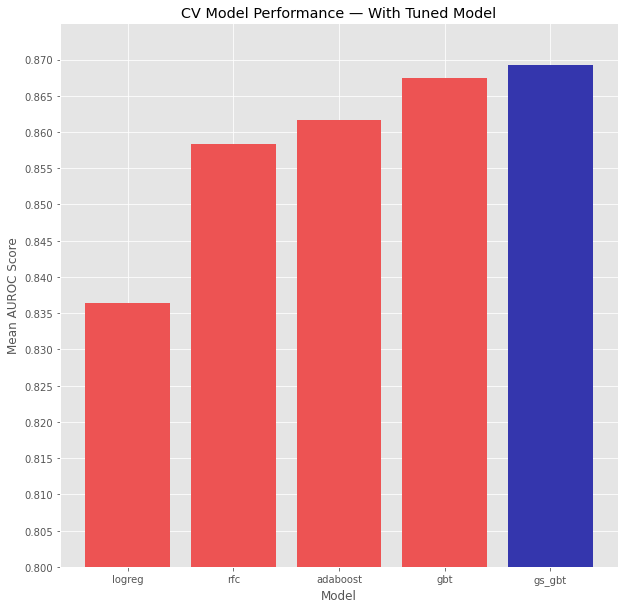

In [47]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.bar(model_names, mean_cv_scores, label='Mean ROC-AUC Scores',
    color=['#3436ad' if x == 'gs_gbt' else '#ed5353' for x in model_names])
ax.set_xticks(list(range(len(model_names))))
ax.set_xticklabels(model_names)
ax.set(ylim=(.8, .875))
ax.set_yticks(np.arange(.8, .875, .005))
ax.set_xlabel('Model')
ax.set_ylabel('Mean AUROC Score')
ax.set_title('CV Model Performance — With Tuned Model')
plt.savefig('images/models_compared.png', dpi=150);

#### The tuned GBT classifier performs marginally better than the untuned one. 
#### This will be the final model.

In [48]:
final_model = gs_gbt.best_estimator_

### Test score of final model

In [49]:
model_cv_results(
    final_model, 
    X_test_scaled, 
    y_test, 
    cv=False,
    metrics=['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
)

# Including multiple additional metrics for reference.
# I discuss this further in the conclusions.

,score
accuracy,0.842744
precision,0.695652
recall,0.478775
f1,0.567189
roc_auc,0.853698


In [50]:
# Training score for comparison
gs_gbt_results

,train_score,mean_cv_score
accuracy,0.873989,0.858412
roc_auc,0.898490,0.869311


#### Final model performance and evaluation:

The final model has an **AUROC score of about 0.8537**. 85.37% of the time, the model will assign a higher probability to someone who received the vaccine than to someone who didn't.

This model is a **gradient boosted trees algorithm**, which is designed to essentially learn from its mistakes. Each subsequent learner is trained on the residuals of the previous learner. The algorithm incorporates gradient descent in order to minimize loss.

The predictor that has the most influence on the model is whether or not someone received a **doctor's recommendation** to take the vaccine. As seen in the chart below, other influential predictors include an individual's **opinion about the risk H1N1 poses to them**, as well as whether they have **health insurance**.

### Feature importances

In [51]:
def plot_feature_importances(
    model, features=X_train_scaled.columns.tolist(), return_df=False, 
    cutoff=0, figsize=(5,13), regression=False, title=False
    ):

    """
    Plots the feature importances of a model. Can also return DataFrame of those importances
    if specified. 
    Defaults to work with tree based models. Set `regresssion` to True in order to plot
    the coefficients of regression models.
    """
    if regression:
        df = pd.DataFrame(
            zip(features, np.abs(model.coef_).tolist()[0]),
            columns=['feature', 'importance']
        ).sort_values(by='importance', ascending=True)[-cutoff:]
    else:
        df = pd.DataFrame(
            zip(features, model.feature_importances_.tolist()),
            columns=['feature', 'importance']
        ).sort_values(by='importance', ascending=True)[-cutoff:]

    fig, ax = plt.subplots(figsize=figsize)
    ax.barh(y=df['feature'], width=df['importance'], color='#ed5353')
    ax.set_ylabel('Feature')
    ax.set_xlabel('Importance')
    if title:
        ax.set_title(title)
    elif cutoff != 0:
        ax.set_title(f'Top {cutoff} features in the model')
    else:
        ax.set_title(f'Feature importances')
    plt.show();
    
    if return_df:
        return df[::-1]

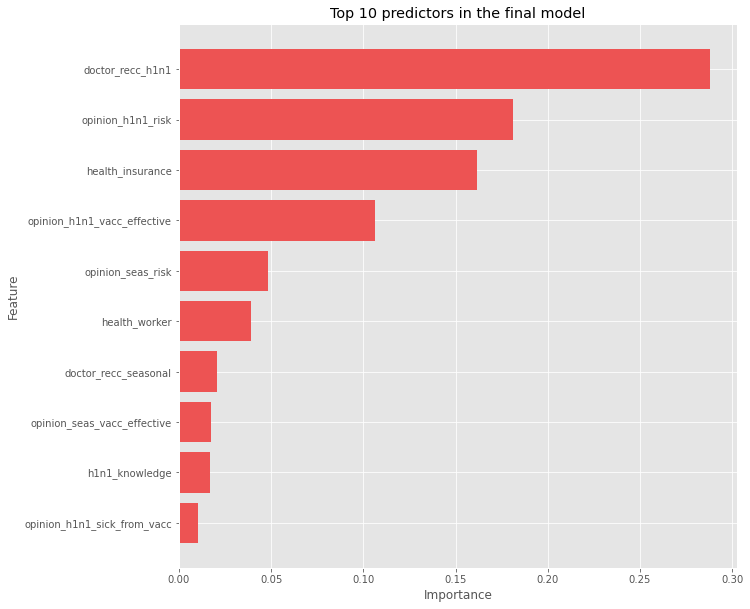

In [52]:
plot_feature_importances(
    final_model,
    figsize=(10,10),
    cutoff=10,
    title='Top 10 predictors in the final model'
)

## Conclusions
### Recommendations

The stakeholder, a public health agency, should take the following measures in order to fight vaccine hesitancy. These recommendations are based on features that the model predicts are most indicative of whether someone will get vaccinated. 

* **Doctor's orders:** Instruct doctors and health practitioners to recommend disease-preventing vaccines. Even in a pandemic, the model shows that someone is far less likely to get vaccinated if they haven't gotten a doctor's recommendation. 

* **PSAs:** Raise public awareness about the risks of the virus. The model is able to use someone's opinions about the virus to predict whether they will take a vaccine. People are more likely to get vaccinated if they view an infectious virus as a risk to themselves. 

* **Access**: Increase access to healthcare and ensure that vaccines are available for free even to those who don't have coverage. The model is less likely to predict that someone got the vaccine if they don't have health insurance. It's important to remove this obstacle and ensure that the public is aware of the vaccine's availability.

### Next steps

Are these findings generalizable to other public health crises? The data used in this analysis pertains to the swine flu pandemic, which ended more than a decade ago. It might be beneficial to find similar data about the current COVID-19 pandemic to see if the the findings would be similar. Public health communication about COVID-19 has arguably been more pervasive than for the swine flu. It's possible that that has had an effect on vaccination rates when compared to swine flu.

### Limitations
For comparison, I included various additional metric scores with the test set results. Of note, the final model has a recall score of 0.4788. This means that of all people who did in fact get the vaccine, the model will correctly predict them as positive cases 47.88% of the time. This is rather low. However, in the context of life-saving vaccines it is probably better to undercount the vaccinated. This way a public health authority will end up targeting more of the general population with pro-vaccine messaging and access, and hopefully capturing more of the unvaccincated population.

### Appendix
#### Saving charts for presentation

In [53]:
# Charts based on the top three features

In [54]:
chart_data = data[[
    'doctor_recc_h1n1', 
    'opinion_h1n1_risk', 
    'health_insurance', 
    'h1n1_vaccine'
]]

In [55]:
opinions = {}
for o in range(1,6):
    subset = chart_data.query(f"opinion_h1n1_risk == {o}")
    opinion = dict(subset)['h1n1_vaccine'].value_counts(normalize=True)*100
    opinions[o] = opinion

doc_recc = {}
for r in [0,1]:
    subset = chart_data.query(f"doctor_recc_h1n1 == {r}")
    recc = dict(subset)['h1n1_vaccine'].value_counts(normalize=True)*100
    doc_recc[r] = recc

insurance = {}
for i in [0,1]:
    subset = chart_data.query(f"health_insurance == {i}")
    ins = dict(subset)['h1n1_vaccine'].value_counts(normalize=True)*100
    insurance[i] = ins

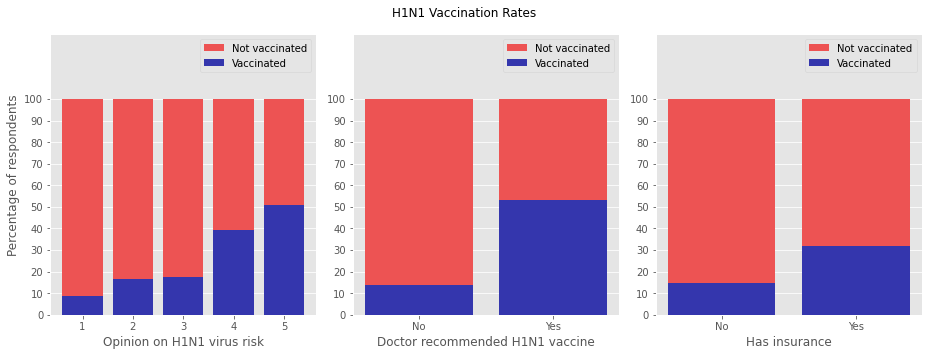

In [56]:
opinion_vaccinated = [o[1] for o in opinions.values()]
opinion_unvaccinated = [o[0] for o in opinions.values()]
recc_vaccinated = [r[1] for r in doc_recc.values()]
recc_unvaccinated = [r[0] for r in doc_recc.values()]
ins_vaccinated = [i[1] for i in insurance.values()]
ins_unvaccinated = [i[0] for i in insurance.values()]

fig, ax = plt.subplots(ncols=3, figsize=(13,5))

ax[0].bar(
    x=list(opinions.keys()), height=opinion_unvaccinated, 
    bottom=opinion_vaccinated, label='Not vaccinated', color=['#ed5353']
)
ax[0].bar(
    x=list(opinions.keys()), height=opinion_vaccinated, 
    label='Vaccinated', color=['#3436ad']
)
ax[0].set(ylim=(0, 130))
ax[0].set_yticks(range(0, 110, 10))
ax[0].set_xlabel('Opinion on H1N1 virus risk')
ax[0].set_ylabel('Percentage of respondents')
ax[0].legend(loc='best')
ax[0].grid(axis='x')

ax[1].bar(
    x=list(doc_recc.keys()), height=recc_unvaccinated, 
    bottom=recc_vaccinated, label='Not vaccinated', color=['#ed5353']
)
ax[1].bar(
    x=list(doc_recc.keys()), height=recc_vaccinated, 
    label='Vaccinated', color=['#3436ad']
)
ax[1].set(ylim=(0, 130))
ax[1].set_yticks(range(0, 110, 10))
ax[1].set_xlabel('Doctor recommended H1N1 vaccine')
ax[1].set_xticks([0, 1])
ax[1].set_xticklabels(['No', 'Yes'])
ax[1].legend(loc='best')
ax[1].grid(axis='x')

ax[2].bar(
    x=list(insurance.keys()), height=ins_unvaccinated, 
    bottom=ins_vaccinated, label='Not vaccinated', color=['#ed5353']
)
ax[2].bar(
    x=list(insurance.keys()), height=ins_vaccinated, 
    label='Vaccinated', color=['#3436ad']
)
ax[2].set(ylim=(0, 130))
ax[2].set_yticks(range(0, 110, 10))
ax[2].set_xlabel('Has insurance')
ax[2].set_xticks([0, 1])
ax[2].set_xticklabels(['No', 'Yes'])
ax[2].legend(loc='best')
ax[2].grid(axis='x')

fig.suptitle('H1N1 Vaccination Rates')
plt.savefig('images/top_3_features.png', dpi=150)
plt.tight_layout();

In [57]:
# Charts for the best- and worst-case scenarios

In [58]:
worst_scenario = (chart_data.query(
    """doctor_recc_h1n1 == 0 &\
       opinion_h1n1_risk == 1 &\
       health_insurance == 0"""
)['h1n1_vaccine'].value_counts(normalize=True)).sort_index()*100

best_scenario = chart_data.query(
    """doctor_recc_h1n1 == 1 &\
       opinion_h1n1_risk == 5 &\
       health_insurance == 1"""
)['h1n1_vaccine'].value_counts(normalize=True).sort_index()*100

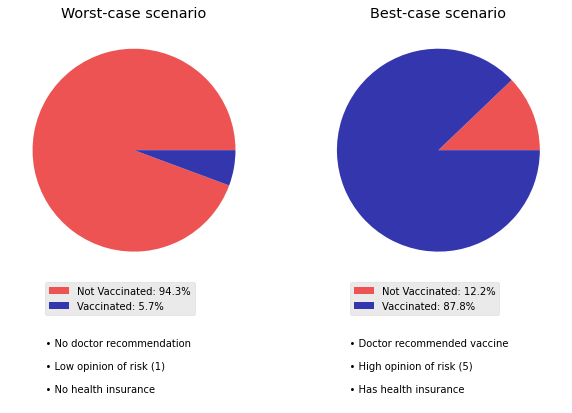

In [59]:
fig, ax = plt.subplots(ncols=2, figsize=(10,5))

ax[0].pie(
    x= worst_scenario,
    labels=[
        f'Not Vaccinated: {worst_scenario[0]:.1f}%', 
        f'Vaccinated: {worst_scenario[1]:.1f}%'], 
    labeldistance=None,
    colors=['#ed5353', '#3436ad']
    )
ax[0].set_title('Worst-case scenario')
ax[0].annotate(
    text=
    """
    • No doctor recommendation\n
    • Low opinion of risk (1)\n
    • No health insurance 
         """,
    xy=(0,0),
    xytext=(-1,-2.5)
)
ax[0].legend(loc=(0.15, -0.15))

ax[1].pie(
    x= best_scenario,
    labels=[
        f'Not Vaccinated: {best_scenario[0]:.1f}%', 
        f'Vaccinated: {best_scenario[1]:.1f}%'], 
    labeldistance=None,
    colors=['#ed5353', '#3436ad']
    )
ax[1].set_title('Best-case scenario')
ax[1].annotate(
    text=
    """
    • Doctor recommended vaccine\n
    • High opinion of risk (5)\n
    • Has health insurance 
         """,
    xy=(0,0),
    xytext=(-1,-2.5)
)
ax[1].legend(loc=(0.15, -0.15))
plt.savefig('images/best_worst_scenario.png', dpi=150);

In [60]:
# Total time:
t = time.time() - start_time
print(f'Notebook run time: {t//60:.0f} minutes and {t%60:.0f} seconds')

Notebook run time: 3 minutes and 24 seconds
